# Two Moons: Tackling Bimodal Posteriors

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

np.set_printoptions(suppress=True)

import bayesflow as bf
from bayesflow import benchmarks

This example will demonstrate amortized estimation of a somewhat strange Bayesian model, whose posterior evaluated at the origin $x = (0, 0)$ of the "data" will resemble two crescent moons. The forward process is a noisy non-linear transformation on a 2D plane:

$$
\begin{align}
x_1 &= -|\theta_1 + \theta_2|/\sqrt{2} + r \cos(\alpha) + 0.25\\
x_2 &= (-\theta_1 + \theta_2)/\sqrt{2} + r\sin{\alpha}
\end{align}
$$

with $x = (x_1, x_2)$ playing the role of "observables", $\alpha \sim \text{Uniform}(-\pi/2, \pi/2)$, $r \sim \text{Normal}(0.1, 0.01)$, and a prior over the 2D parameter vector $\theta = (\theta_1, \theta_2)$:

$$
\begin{align}
\theta_1, \theta_2 \sim \text{Uniform}(-1, 1)
\end{align}
$$

This method is typically used for benchmarking simulation-based inference (SBI) methods (see https://arxiv.org/pdf/2101.04653) and any method for amortized Bayesian inference should be capable of recovering the two moons posterior *without* using a gazillion of simulations. Note, that this is a considerably harder task than modeling the common unconditional two moons data set used often in the context of normalizing flows.

The two moons generative model, along with all benchmarks from https://arxiv.org/pdf/2101.04653, exists as a standalone object in the `bayesflow.benchmarks` module. So let's import it using the `Benchmark` helper class.

In [3]:
benchmark = benchmarks.Benchmark("two_moons", mode="posterior")

INFO:root:Performing 2 pilot runs with the two_moons model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 2)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 2)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


## Inference Network and Amortizer
We will use a neural spline flow (https://arxiv.org/abs/1906.04032) for modeling the posterior, as these are specialized for locally weird posteriors. By default, some weight regularization and dropout will be applied during training. These can be modified through the `coupling_settings` keyword of the `InvertibleNetwork`.

In [4]:
inference_net = bf.networks.InvertibleNetwork(
    num_params=2, coupling_design="spline", num_coupling_layers=4, permutation="learnable"
)

amortizer = bf.amortizers.AmortizedPosterior(inference_net)

## Trainer
The `benchmark` object already contains the two moons generative model to simulate pairs of $(\theta, x)$ and the configurator to arrange them into the corresponding dictionary data structure expected by the `amortizer`.

In [5]:
trainer = bf.trainers.Trainer(
    amortizer=amortizer, configurator=benchmark.configurator, generative_model=benchmark.generative_model, memory=False
)

INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


You have probably noticed, that we are not using any summary network, since the two moons "observables" are single 2D vectors. This is the reason why the simulator outputs will be going into the `direct_conditions` key of the configured output.

To make the problem more challenging, we will generate $10000$ simulations from the model, which puts us into the "mid-range" of training data availability.

In [6]:
offline_data = benchmark.generative_model(10000)

In [ ]:
%%time
history = trainer.train_offline(offline_data, epochs=30, batch_size=32, validation_sims=200)

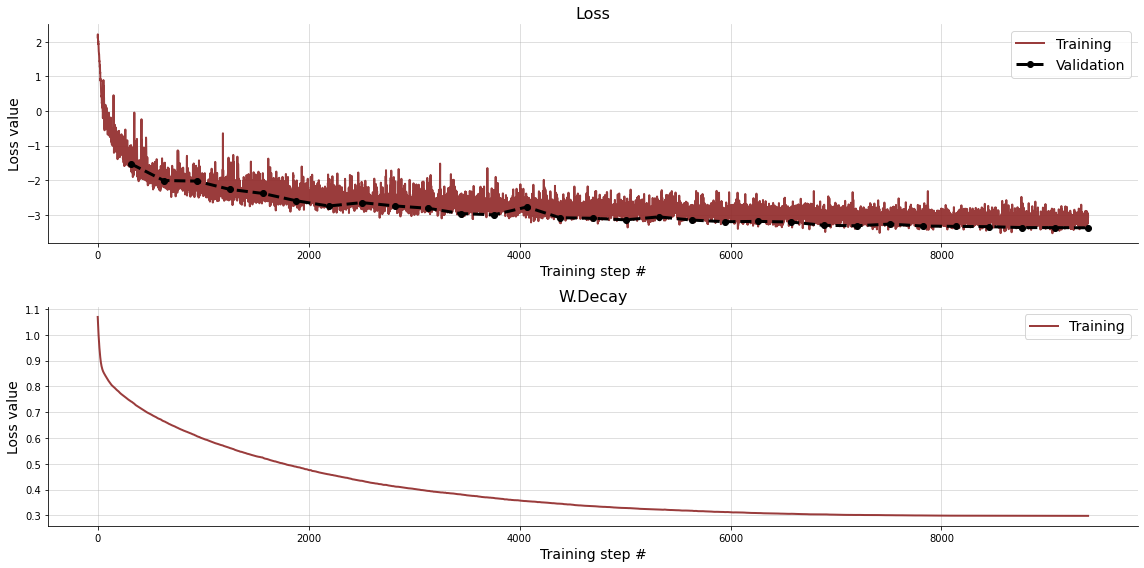

In [8]:
fig = bf.diagnostics.plot_losses(history["train_losses"], history["val_losses"])

## Validation
We can use simulation-based calibration(SBC) for free (due to amortization) checking of computational faithfulness.

1. Talts, S., Betancourt, M., Simpson, D., Vehtari, A., & Gelman, A. (2018). Validating Bayesian inference algorithms with simulation-based calibration. arXiv preprint arXiv:1804.06788.
2. Säilynoja, T., Bürkner, P. C., & Vehtari, A. (2022). Graphical test for discrete uniformity and its applications in goodness-of-fit evaluation and multiple sample comparison. Statistics and Computing, 32(2), 32.

In [9]:
%%time
new_sims = trainer.configurator(trainer.generative_model(500))
posterior_draws = amortizer.sample(new_sims, n_samples=250)

CPU times: total: 438 ms
Wall time: 814 ms


### Global Calibration
For a good calibration, the ECDF trajectories should remain within the simultanoeus confidence bands.

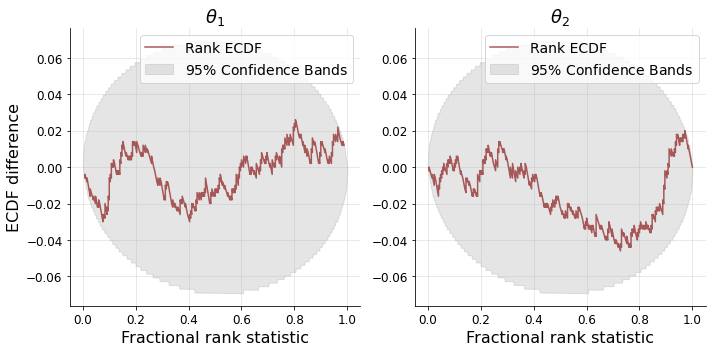

In [10]:
fig = bf.diagnostics.plot_sbc_ecdf(posterior_draws, new_sims["parameters"], difference=True)

### Two Moons Posterior

The two moons posterior at point $x = (0, 0)$ should resemble two crescent shapes. Below, we plot the corresponding posterior samples and posterior density.

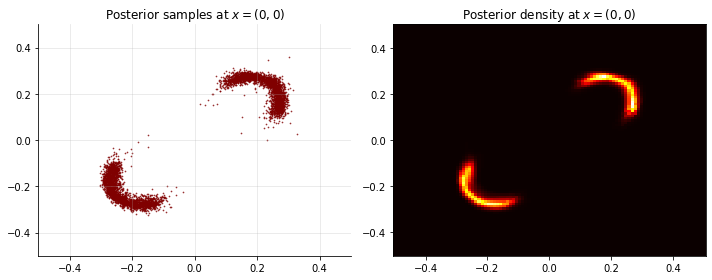

In [93]:
# Prepare figure
f, axarr = plt.subplots(1, 2, figsize=(10, 4))

# Obtain amortized samples
obs_data = np.zeros((1, 2)).astype(np.float32)
samples_at_origin = amortizer.sample({"direct_conditions": obs_data}, n_samples=5000)

# Plot samples
axarr[0].scatter(samples_at_origin[:, 0], samples_at_origin[:, 1], color="maroon", alpha=0.75, s=0.5)
sns.despine(ax=axarr[0])
axarr[0].set_title(r"Posterior samples at $x=(0, 0)$")
axarr[0].grid(alpha=0.3)
axarr[0].set_xlim([-0.5, 0.5])
axarr[0].set_ylim([-0.5, 0.5])

# Compute log density on relevant posterior range
side = np.linspace(-0.5, 0.5, 100)
x, y = np.meshgrid(side, side)
obs_data_rep = np.zeros((10000, 2)).astype(np.float32)
params = np.c_[x.flatten(), y.flatten()]
lpdf = amortizer.log_posterior({"parameters": params, "direct_conditions": obs_data_rep})

# Plot the density map using nearest-neighbor interpolation
axarr[1].pcolormesh(x, y, np.exp(lpdf).reshape(100, 100), cmap=cm.hot)
axarr[1].set_title(r"Posterior density at $x=(0, 0)$")

f.tight_layout()

## Further Experimentation

Feel free to explore the following settings:
1. Change the `coupling_design` argument of the `InvertibleNetwork` to either `affine` or `interleaved`. What do you observe?
2. Try out `mc_dropout=True` in the `coupling_settings` of the `InvertibleNetwork`. What happens to the spread of the posterior samples?
3. Can you make the network overfit by removing all regularization?
4. What posteriors do different "observed" points $x$ yield?